<span style="font-family:Papyrus; font-size:3em;">Testing Kinetics Models</span>

<span style="font-family:Papyrus; font-size:2em;">Finding Mass Balance Errors</span>

This notebook addresses static tests related to mass balance errors, with a focus
on stoichiometric inconsistencies (SI).
Given a reaction network for a metabolic cycle (i.e., there are no boundary reactions) with stoichiomery matrix $N$, a SI exists if there is no vector of
masses $m = (m_1, \cdots, m_n)$ with $m_i > 0$ such that $N^T m = 0$.
That is, no legal assignment of masses to chemical species results in mass balance.

# Programminmg Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
  !pip install scipy
#    
# Constants for standalone notebook
if not IS_COLAB:
    COMMON_DIR = "/home/ubuntu/advancing-biomedical-models/common"
    CODE_DIRS = [COMMON_DIR]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_15"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    COMMON_DIR = ["/content/drive/MyDrive/Winter 2021/common"]
    CODE_DIRS = [COMMON_DIR]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/15_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [2]:
# Python packages used in this section
import os
import scipy

import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from SBMLLint.tools.sbmllint import lint
from scipy.optimize import linprog
import util

# Impact of Mass Balance Errors on Simulations

Here we show the impact of mass balance errors for a simple reaction network involving phosphorylation and hydrolysis of ATP.

In [3]:
ATP1_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

In [4]:
def plotModel(model, endTime=50, title="", numPoint=100, isPlot=True):
    """
    Constructs time plot of an antimony model.
    
    Parameters
    ----------
    model: str
    """
    rr = te.loada(model)
    figure, ax = plt.subplots(1)
    data = rr.simulate(0, endTime, numPoint)
    for col in data.colnames[1:]:
        ax.plot(data["time"], data[col])
    ax.set_xlabel("time")
    ax.set_ylabel("concentration")
    ax.legend(data.colnames[1:])
    ax.set_title(title)
    if not isPlot:
        plt.close()
    return data
    
# Tests
data = plotModel(ATP1_MODEL, isPlot=False)
assert(len(data) > 0)

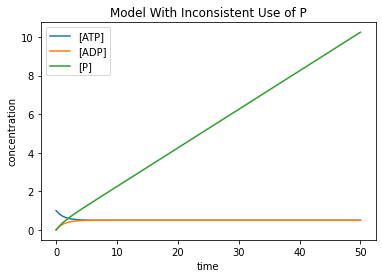

In [5]:
_ = plotModel(ATP1_MODEL, title="Model With Inconsistent Use of P")

The simulation makes it clear that there is a problem with this reaction network since ``[P]`` increases without bound.
Looking closely, we determine that inorganic phosphate is consider in ``J0`` but not in ``J1``.
There are two ways to fix this: (a) include ``P`` in ``J1`` and (b) delete ``P`` from ``J0``. Both work, as shown below.

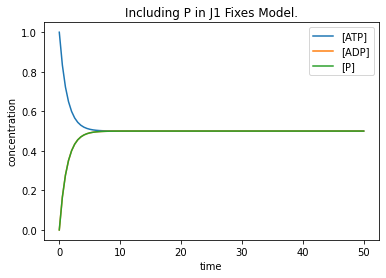

In [6]:
ATP2_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP + P -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""
_ = plotModel(ATP2_MODEL, title="Including P in J1 Fixes Model.")

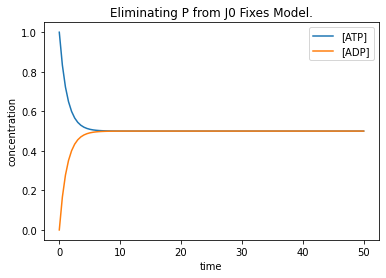

In [7]:
ATP3_MODEL = """
J0: ATP -> ADP; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""
_ = plotModel(ATP3_MODEL, title="Eliminating P from J0 Fixes Model.")

# Linear programming in python

**scipy.optimize.linprog**

scipy.optimize.linprog(c, A_ub=None, b_ub=None, A_eq=None, b_eq=None, bounds=None, method='simplex', callback=None, options=None)[source]

    Minimize a linear objective function subject to linear equality and inequality constraints.

    Linear Programming is intended to solve the following problem form:

    Minimize: c^T * x

    Subject to: A_ub * x <= b_ub
        A_eq * x == b_eq

    Parameters:	

    c : array_like

        Coefficients of the linear objective function to be minimized.

    A_ub : array_like, optional

        2-D array which, when matrix-multiplied by x, gives the values of the upper-bound inequality constraints at x.

    b_ub : array_like, optional

        1-D array of values representing the upper-bound of each inequality constraint (row) in A_ub.

    A_eq : array_like, optional

        2-D array which, when matrix-multiplied by x, gives the values of the equality constraints at x.

    b_eq : array_like, optional

        1-D array of values representing the RHS of each equality constraint (row) in A_eq.



## Feasible solution

$min_{x_0, x_1} x_0 + x_1$

such that:
- $3 x_0 + x_1 = 6$
- $x_0 + 2 x_1 = 4$
- $x_0, x_1 \geq 0 \approx 10^{-5}$

In [8]:
# Solving the linear program
c = [1, 1]

A_eq = [[3, 1], [1, 2]]

b_eq = [6, 4]

x0_bounds = (10e-5, None)  # Use 10e-5 as a lower bound

x1_bounds = (10e-5, None)

res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[x0_bounds, x1_bounds])
res

     con: array([1.84817495e-10, 9.23767729e-11])
     fun: 2.7999999999260856
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.6, 1.2])

## Infeasible solution

In the above example, use $-3 x_0 + x_1 = 6$ instead of $3 x_0 + x_1 = 6$.

In [9]:
A_eq = [[-3, 1], [1, 2]]
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[x0_bounds, x1_bounds])
res

     con: array([6.23608595, 0.77925741])
     fun: 1.8741509008125365
 message: 'The algorithm terminated successfully and determined that the problem is infeasible.'
     nit: 4
   slack: array([], dtype=float64)
  status: 2
 success: False
       x: array([0.52755921, 1.34659169])

# Detecting Stoichiometric Inconsistencies (SI)

Detecting an SI requires that we determine that there is no mass vector $m$ that results in
all reactions being mass balanced.
Formally, this means that there is no $m$ such that $N^Tm = 0$. 

This condition can be re-cast as satisfying the constraints of a linear program.
That is, an SI exists if the linear program that corresponds to constraints $N^Tm = 0$ is infeasible.

The sections below describe how to do linear programming in python, followed by two problems to solve related to SI detection.

## Detecting SIs in BioModels 255 

In [10]:
# Transpose of the stoichiometry matrix for a subset of BioModels 255, Erb signaling pathways.
NT = np.array([
    [0, -2, 1, 0, 0, 0, 0],
    [0, -1, 0, 0, 0, -1, 1],
    [-1, 1, 0, -1, 0, 0, 0],
    [-1, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, -1],
    [0, 0, 0, 0, 1, -1, 0]
])

**Questions**
1. Find ``c``, ``A_ub``, ``b_ub``, ``A_eq``, ``b_eq`` for BioModels 255 that are the arguments for ``linprog`` for for solving for stoichiometric inconsistencies.
1. Use ``linprog`` to determine if there is a stoichiometric inconsistency in this model.


### Solution

In [11]:
# c
numRow, numCol = np.shape(NT)
c = np.repeat(1, numCol)
c

array([1, 1, 1, 1, 1, 1, 1])

In [12]:
# b_eq
b_eq = np.repeat(0, numRow)
b_eq

array([0, 0, 0, 0, 0, 0])

In [13]:
A_eq = NT
bounds = []
for _ in range(numCol):
    bounds.append((10e-5, None))
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
res

     con: array([ 7.39121638e-04,  7.39121638e-04,  7.39121638e-04, -3.35018471e-15,
        0.00000000e+00,  0.00000000e+00])
     fun: 0.006120288476860554
 message: 'The algorithm terminated successfully and determined that the problem is infeasible.'
     nit: 4
   slack: array([], dtype=float64)
  status: 2
 success: False
       x: array([0.0010546 , 0.00073912, 0.00073912, 0.00042364, 0.0010546 ,
       0.0010546 , 0.0010546 ])

## Analyze *all* of Model 255

**Questions**
1. How many reactions are there in the model? Chemical species?
1. Analyze SIs for the entire model. (See `BIOMD0000000255_url.xml`` in common.)

### Solution

In [14]:
path = os.path.join(COMMON_DIR, "BIOMD0000000255_url.xml")
rr255 = te.loads(path)

In [15]:
print("Number of species: %d" % rr255.getNumFloatingSpecies())
print("Number of reactions: %d" % rr255.getNumReactions())

Number of species: 500
Number of reactions: 827


In [16]:
N = rr255.getFullStoichiometryMatrix()
NT = N.transpose()

In [17]:
# c
numRow, numCol = np.shape(NT)
c = np.repeat(1, numCol)

In [18]:
# b_eq
b_eq = np.repeat(0, numRow)

In [19]:
A_eq = NT
bounds = []
for _ in range(numCol):
    bounds.append((10e-5, None))
try:
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, options={"tol": 10e-5})
except ValueError as err:
    print(err)

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/ipykernel_launcher.py:6: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



The algorithm terminated successfully and determined that the problem is infeasible.


# Detecting Mass Balance Errors using GAMES

The GAMES algorithm (Shin & Hellerstein, Bioinformatics, 2019) is a graphical technique
that analyzes reaction networks to detect SI and isolate the underlying causes.

GAMES is in the SBMLLint ``pip`` installable package. It can be run at the command line
via ``games <SBML file>``. It can also be run programmatically, such as within a Jupyter notebook.
Below, we show how to apply the GAMES to the above examples.

We begin by applying GAMES to a model of ATP hydrolysis and synthesis.

In [20]:
_ = lint(ATP1_MODEL, mass_balance_check="games")

Model analyzed...
At least one error found.


ADP = ATP by reaction(s):
1. J1: ADP -> ATP

However, ADP < ATP by reaction(s):
2. J0: ATP -> ADP + P


----------------------------------------------------------------------



**********************************************************************




GAMES detected that the first model is stoichiometric inconsisent. Further, GAMES provides a simple argument for how this detection is made.
Statement (1) explains that GAMES inferred that the mass of ``ADP`` is equal to the mass of ``ATP``.
However, this is contradicted by a second finding that the mass of ``ADP`` is less than the mass of ``ATP``.

## Using Games

**Question**
1. Apply GAMES to BioModels 255

### Solution

In [21]:
# Occasional there are non-ASCII characters in the BioModels files. This logic removes them.
if False:
    newPath = os.path.join(COMMON_DIR, "BIOMD0000000255_urla.xml")
    util.makeAsciiFile(path, newPath)
    path = newPath

In [22]:
_ = lint(path, mass_balance_check="games")

Model analyzed...
At least one error found.


c155 = c86 by reaction(s):
1. v538: c155 -> c86

c86 = c159 by reaction(s):
2. v600: c159 -> c86

However, c155 < c159 by reaction(s):
3. v12: c10 + c155 -> c159


----------------------------------------------------------------------


c154 = c86 by reaction(s):
1. v537: c154 -> c86

c86 = c160 by reaction(s):
2. v601: c160 -> c86

However, c154 < c160 by reaction(s):
3. v13: c10 + c154 -> c160


----------------------------------------------------------------------


c156 = c86 by reaction(s):
1. v539: c156 -> c86

c86 = c161 by reaction(s):
2. v602: c161 -> c86

However, c156 < c161 by reaction(s):
3. v14: c10 + c156 -> c161


----------------------------------------------------------------------


c15 = c17 by reaction(s):
1. v166: c15 -> c17

c17 = c86 by reaction(s):
2. v525: c17 -> c86

c86 = c18 by reaction(s):
3. v526: c18 -> c86

c18 = c23 by reaction(s):
4. v175: c23 -> c18

However, c15 < c23 by reaction(s):
5. v212: c22 + c15 -

# Other Errors Detectable By Static Analysis

There are other errors in reaction networks that can be detected statically. Systems such as MEMOTE detect the following errors:
- *Blocked reactions* are reactions where one or more reactant is never present and so the reaction never ocurs.
- *Dead end metabolite* are chemical species that are produced but not consumed.
- *Orphan metabolites* are chemical species that are consumed but not produced.
- *Charge imbalance* reactions are reactions that do not preserve the charge of the reactants in the products.

The foregoing errors apply to the mass transfer part of reactions. Of course, errors are also possible in the kinetics laws.
Among these errors are:
- *Incorrect reference to chemical species*. To illustrate, consider a reaction in which the modeler intended to use mass action kinetcs, but
wrote the reaction as ``A -> B; kB``.
- *Errors in the function used in the kinetics law*. A common example here is to inadevertently use zeroth order kinetics for
the degradation of a chemical species.
For example, ``B ->; k``. The problem is that this can result in ``B`` becoming negative since its value is reduced
regardless of whether ``B`` is present. Clearly, we cannot have a negative concentration.

# Application to Glycolytic Oscillations
This section applies the idea of model testing to our running example of glycolytic oscillations.
We begin by introduce several constants.
Constants are in all capital letters; they are assigned once, and their values do not change.

In [23]:
# Constants used in the section
WOLF_MODEL = os.path.join(COMMON_DIR, "Jana_WolfGlycolysis.antimony")
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = te.loada(WOLF_MODEL)

In this section, we consider tests to verify the simulation of glycolytic oscillations used in our running example. The use case considered is one in which a team plans to modify the original model.
This may involve both the addition and removal of reactions.

Recall that the reactions in this model are:

  ``
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;``

We begin by checking if the Wolf model has any stoichiometric inconsistencies.
First, we create the antimony model as a string.

In [24]:
WOLF_ANTIMONY = ROADRUNNER.getAntimony()

Then, we check it.

In [25]:
_ = lint(WOLF_ANTIMONY, mass_balance_check="games")

Model analyzed...
No error found.
